# Fremskrivning af epidemikurven i Danmark

Dette dokument danner en eksponentiel fremskriver epidemikurven ud fra dagsaktuelle tal 
for smittede, indlagt og døde. 

## Metode
Vi anvender eksponentiel fremskrivning.

Det er en meget grovkornet metode, som kun kan bruges til kortsigtede fremskrivninger, da den ikke tager højde for
at epidemien over tid har færre og færre raske at ramme (dvs. at kurven begynder at bue nedad).

Den er dog relevant, da det er en fin måde at vise aktuelle data på og få en idé om den aktuelle vækstrate.

## Datagrundlag

Data er indhentet fra Sundhedsstyrelsens hjemmeside for 
[COVID-19 tal og overvågning](https://www.sst.dk/da/corona/tal-og-overvaagning).

Læs mere om datasættet på https://github.com/covid-19-sim/covid-19.sst.dk

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.optimize

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/covid-19-sim/covid-19.sst.dk/master/covid-19-dk.csv',
                 parse_dates=['Date'])

df

,Date,Tested,Confirmed,Hospitalised,ICU,ICU and ventilator,Death count
0,2020-03-11,NaN,NaN,0,0,0,1.0
1,2020-03-12,NaN,NaN,19,3,0,1.0
2,2020-03-13,NaN,NaN,23,4,0,1.0
3,2020-03-14,573.0,37.0,23,4,0,3.0
4,2020-03-15,1270.0,82.0,28,2,0,4.0
5,2020-03-16,2246.0,156.0,62,10,0,5.0
6,2020-03-17,3151.0,232.0,82,18,4,6.0
7,2020-03-18,4310.0,315.0,129,24,18,10.0
8,2020-03-19,6097.0,422.0,153,30,27,16.0
9,2020-03-20,7212.0,525.0,186,37,32,19.0


In [3]:
# Kontroller at data har det forventede format
for c in ['Date', 'Tested', 'Confirmed', 'Hospitalised', 'ICU', 'ICU and ventilator', 'Death count']:
    assert c in df.columns    

In [4]:
epidemi_start = np.min(df['Date'])

df['Day'] = df['Date'] - epidemi_start
df['Day N'] = df['Day'].dt.days


## Faktiske indlæggelser og dødsfald
Datasættet ser således ud når vi tegner graferne med henholdsvis lineær og logaritmisk y-akse.
Husk at en ret linie på logaritmisk y-akse svarer til konstant procentuel daglig tilvækst.   

In [5]:
# Udvælg data vi interesserer os for
OVERSKRIFTER = {'Hospitalised': 'Indlagte', 
                'ICU': 'Intensiv', 
                'ICU and ventilator': 'Intensiv med respirator', 
                'Death count': 'Døde'}

kolonner = list(OVERSKRIFTER.keys())

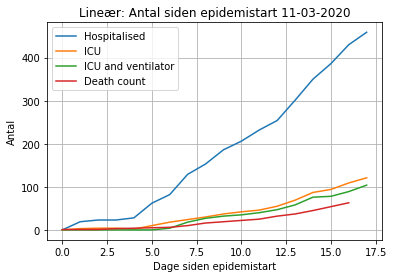

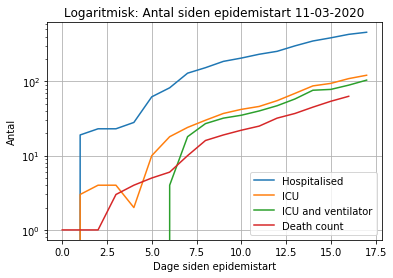

In [6]:
for is_log_plot, titel in [[False, "Lineær"], [True, "Logaritmisk"]]:
    ax = df.plot(x='Day N', y=kolonner, grid=True, logy=is_log_plot,
            title=f'{titel}: Antal siden epidemistart {epidemi_start.date().strftime("%d-%m-%Y")}')
    plt.xlabel('Dage siden epidemistart')
    plt.ylabel('Antal')
    plt.show()

## Eksponentiel fremskrivning

Vi estimerer $a$ og $b$ en simpel eksponentialfunktion til dødsfaldskurven, 

$$\hat{y} = a e^{b x}$$ 

$x$ er dage siden epidemistart, $\hat{y}$ er det estimere antal døde. 

SciPy har en indbygget funktion til at dette, `curve_fit`:

In [7]:
# Hvis ikke vi har observationen, så drop rækken
df_renset = df[['Day N'] + kolonner].dropna()

x_data = df_renset['Day N']

def exp_func(x, a, b):
    return a * np.exp(b * x)

def estimer_a_b(ys):
    popt, pcov = scipy.optimize.curve_fit(exp_func, x_data, ys)
    a,b = popt
    return a,b    

In [8]:
# Estimer alle kolonnerne
estimater = {}

for k in kolonner:
    y_data = df_renset[k]
    a,b = estimer_a_b(y_data)
    print(f'{k}: a = {a}')
    print(f'{k}: b = {b}')
    estimater[k] = {'a': a, 'b': b, 'y_data': y_data} 


Hospitalised: a = 37.20243659347389
Hospitalised: b = 0.15734802379716167
ICU: a = 5.999836494361169
ICU: b = 0.18464358093335967
ICU and ventilator: a = 4.333797449512265
ICU and ventilator: b = 0.19463617151343968
Death count: a = 2.802590783850126
Death count: b = 0.19692574906418783


Den daglige vækstrate er $${{\hat{y}_{t+1}}\over\hat{y}_t} = e^b$$ hvor $t$ angiver dage siden epidemistart.

In [9]:
# Vis den daglige vækstrate
for k in kolonner:
    daglig_vaekstrate = np.exp(estimater[k]['b'])
    print(f'{OVERSKRIFTER[k]:30}: Daglig vækst i antal: {int(100*(daglig_vaekstrate-1))}%')

Indlagte                      : Daglig vækst i antal: 17%
Intensiv                      : Daglig vækst i antal: 20%
Intensiv med respirator       : Daglig vækst i antal: 21%
Døde                          : Daglig vækst i antal: 21%


In [10]:
# Højeste dato med en faktisk observation, herefter følger prognosen
day_N_max = int(np.max(x_data))
date_max = datetime.timedelta(days=day_N_max) + epidemi_start

FREMSKRIV_DAGE = 14
x_data_alle = np.arange(0, day_N_max+FREMSKRIV_DAGE+1)
x_data_fremskrivning = x_data_alle[-FREMSKRIV_DAGE-1:]

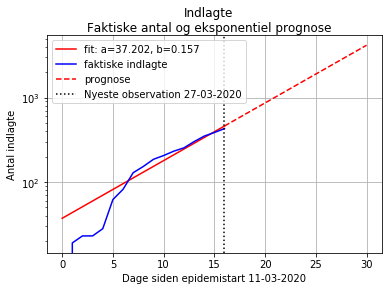

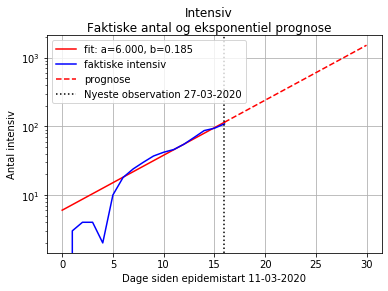

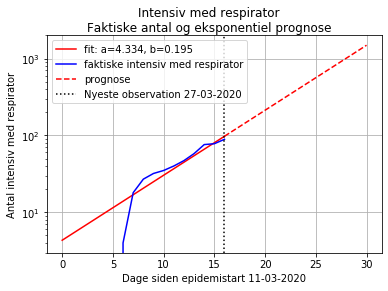

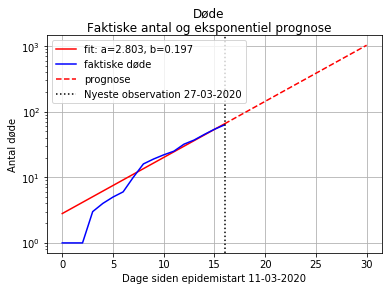

In [11]:
for k in kolonner:
    a = estimater[k]['a']
    b = estimater[k]['b']
    y_data = estimater[k]['y_data']
    overskrift = OVERSKRIFTER[k] 
    
    y_data_fremskrivning = exp_func(x_data_fremskrivning, a, b)
    
    plt.plot(x_data, exp_func(x_data, a, b), 'r-', label='fit: a=%5.3f, b=%5.3f' % (a,b))
    plt.plot(x_data, y_data, 'b-', label=f'faktiske {overskrift.lower()}')
    plt.plot(x_data_fremskrivning, y_data_fremskrivning, 'r--', label='prognose')
    plt.xlabel(f'Dage siden epidemistart {epidemi_start.strftime("%d-%m-%Y")}')
    plt.ylabel(f'Antal {overskrift.lower()}')
    plt.axvline(day_N_max, color='k', linestyle=':', 
                label=f'Nyeste observation {date_max.date().strftime("%d-%m-%Y")}')
    plt.legend()
    plt.suptitle(f'{overskrift}\nFaktiske antal og eksponentiel prognose')
    plt.yscale('log')
    plt.grid()
    
    plt.show()